In [3]:
# Mount Google Drive (if your data is stored there)
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [4]:
# 1. U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return self.conv(dec1)  # Remove sigmoid activation here

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

In [5]:
# IoU Loss Function
class IoULoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(IoULoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Apply sigmoid activation
        inputs = torch.sigmoid(inputs)
        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection

        IoU = (intersection + self.smooth) / (union + self.smooth)

        return 1 - IoU

In [6]:
# 2. 데이터셋 클래스 정의 (이미지와 마스크를 메모리에 로드)
class InMemoryDataset(Dataset):
    def __init__(self, images, masks, transform=None, mask_transform=None):
        self.images = images  # PIL 이미지 리스트
        self.masks = masks    # PIL 이미지 리스트
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [7]:
# 3. 학습 루프 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    best_model_state_dict = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Save the model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            print("Model saved.")

    print("Training complete.")
    # Load best model weights
    model.load_state_dict(best_model_state_dict)

    # Plotting the training and validation loss
    plt.figure()
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.savefig('loss_curve.png')
    plt.show()

    return best_val_loss

In [8]:
# 4. 모델 로드 및 예측 함수
def load_model(model_path, model, device):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded successfully.")
    return model

In [9]:
def predict(model, image, device):
    model.eval()
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        output = model(image)
        output = torch.sigmoid(output)  # Apply sigmoid activation
        output = output.squeeze().cpu().numpy()
        output = (output > 0.5).astype(np.uint8) * 255  # 이진화

    return output

In [10]:
# 5. 평가 지표 계산 함수
def compute_metrics(pred, target):
    pred = pred.astype(np.uint8).flatten()
    target = target.astype(np.uint8).flatten()

    intersection = np.sum(pred * target)
    union = np.sum(pred) + np.sum(target) - intersection

    if union == 0:
        iou_score = 1.0  # 만약 예측과 실제값이 모두 0이면 IoU는 1로 설정
    else:
        iou_score = intersection / union

    dice_denominator = np.sum(pred) + np.sum(target)
    if dice_denominator == 0:
        dice_score = 1.0  # 만약 예측과 실제값이 모두 0이면 Dice 계수는 1로 설정
    else:
        dice_score = 2 * intersection / dice_denominator

    accuracy = np.sum(pred == target) / len(pred)

    return iou_score, dice_score, accuracy

In [11]:
# 차이 마스크를 생성하는 함수 정의
def get_difference_mask(predicted_mask, ground_truth_mask):
    # 마스크가 이진 값(0과 255)이라 가정하고 0과 1로 정규화
    pred = predicted_mask / 255
    gt = ground_truth_mask / 255

    # 차이 마스크 생성: 노랑(정확), 빨강(잘못된 양성), 초록(잘못된 음성)
    difference = np.zeros((*pred.shape, 3), dtype=np.uint8)
    difference[(gt == 1) & (pred == 1)] = [255, 255, 0]  # True Positive - 노랑
    difference[(gt == 0) & (pred == 1)] = [255, 0, 0]    # False Positive - 빨강
    difference[(gt == 1) & (pred == 0)] = [0, 255, 0]    # False Negative - 초록

    return difference

Model loaded successfully.

Test set metrics:
Mean IoU: 0.2322
Mean Dice Coefficient: 0.3571
Mean Pixel Accuracy: 0.9560


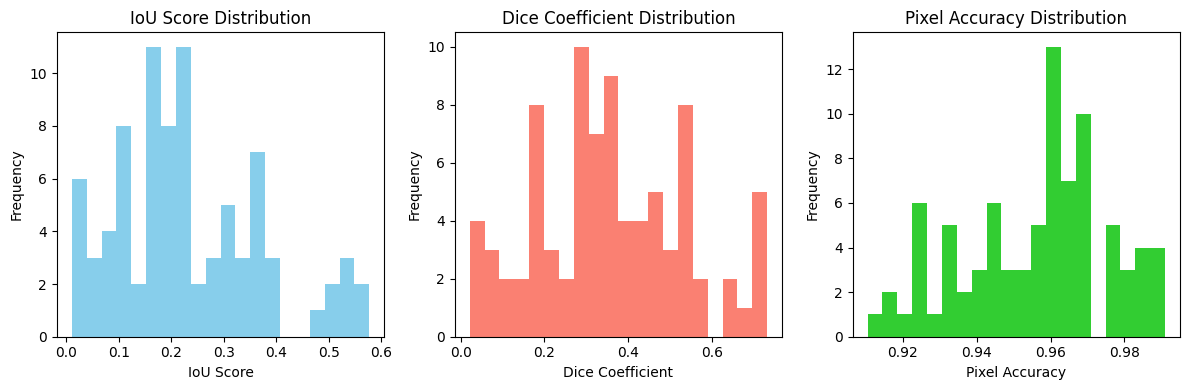

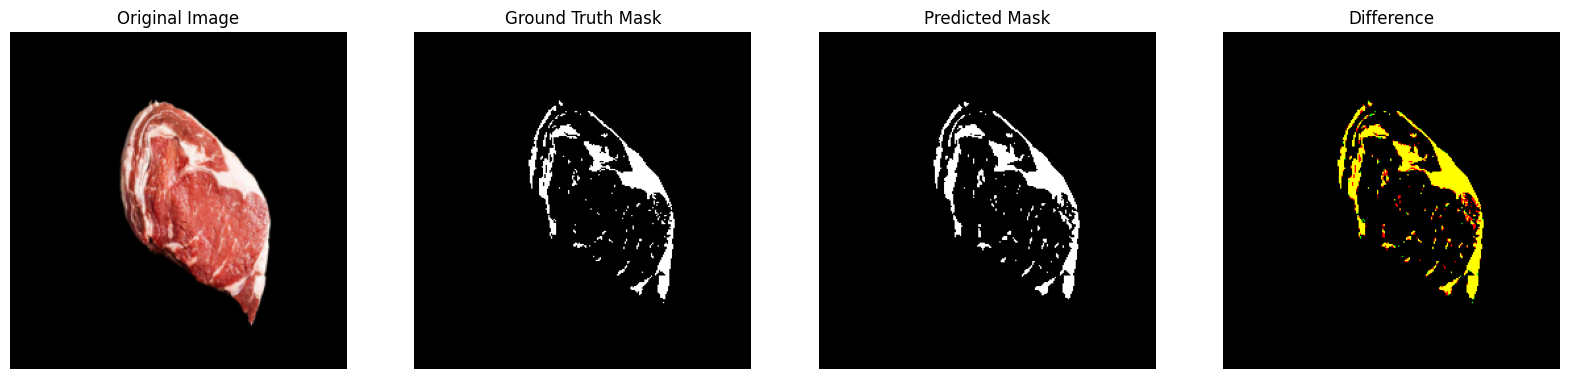

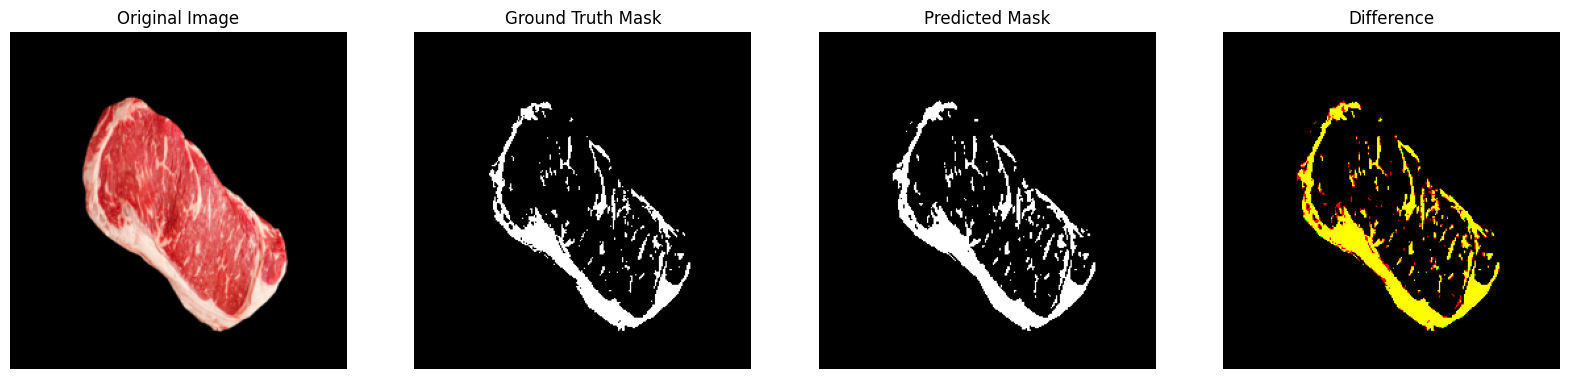

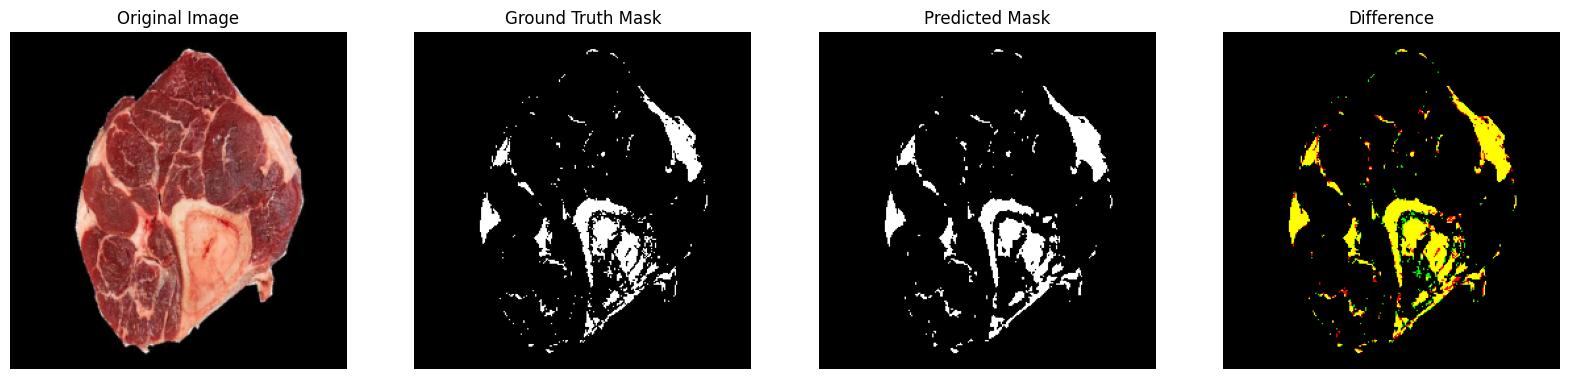

In [12]:
if __name__ == '__main__':
    import warnings

    warnings.filterwarnings("ignore")

    # 절대 경로 설정
    # In Colab, set base_dir to current working directory or specify your path
    # base_dir = os.getcwd()
    base_dir = '/content/drive/MyDrive/24-02-ai-project'  # Update with your path

    # 하이퍼파라미터 및 경로 설정
    images_dir = os.path.join(base_dir, 'fat_separation', 'data')
    masks_dir = os.path.join(base_dir, 'fat_separation', 'mask')
    model_path = os.path.join(base_dir, 'best_fat_separation_unet_model.pth')

    num_epochs = 25
    batch_size = 8
    image_size = (256, 256)

    # 허용되는 이미지 확장자 정의
    allowed_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

    # 지정된 디렉토리에서 이미지 파일만 가져오는 함수
    def get_image_files(directory):
        files = []
        for f in os.listdir(directory):
            if os.path.splitext(f)[1].lower() in allowed_extensions:
                files.append(f)
        return files

    # 이미지와 마스크 파일 가져오기
    image_files = set(get_image_files(images_dir))
    mask_files = set(get_image_files(masks_dir))

    # 이미지와 마스크의 교집합만 사용 (파일명이 동일한 것만)
    common_files = image_files & mask_files

    # 이미지와 마스크의 전체 경로 리스트 생성
    image_paths = sorted([os.path.join(images_dir, f) for f in common_files])
    mask_paths = sorted([os.path.join(masks_dir, f) for f in common_files])

    # 이미지와 마스크를 메모리에 로드
    images_list = []
    masks_list = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        try:
            image = Image.open(img_path).convert('RGB')
            mask = Image.open(mask_path).convert('L')
            images_list.append(image)
            masks_list.append(mask)
        except Exception as e:
            print(f"이미지 또는 마스크를 로드하는 중 오류 발생: {e}")
            continue

    # 데이터 증강 및 증강된 이미지 추가
    augmented_images = []
    augmented_masks = []

    for image, mask in zip(images_list, masks_list):
        # 원본 이미지와 마스크 추가
        augmented_images.append(image)
        augmented_masks.append(mask)

        # 랜덤 수평 뒤집기
        image_hflip = TF.hflip(image)
        mask_hflip = TF.hflip(mask)
        augmented_images.append(image_hflip)
        augmented_masks.append(mask_hflip)

        # 랜덤 수직 뒤집기
        image_vflip = TF.vflip(image)
        mask_vflip = TF.vflip(mask)
        augmented_images.append(image_vflip)
        augmented_masks.append(mask_vflip)

        # 랜덤 회전
        angles = [-30, -15, 15, 30]
        for angle in angles:
            image_rot = TF.rotate(image, angle, fill=0)
            mask_rot = TF.rotate(mask, angle, fill=0)
            augmented_images.append(image_rot)
            augmented_masks.append(mask_rot)

    # 전체 데이터셋의 인덱스 생성
    indices = list(range(len(augmented_images)))

    # 데이터를 훈련, 검증, 테스트 세트로 분할 (0.7:0.15:0.15 비율)
    train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

    # 분할된 인덱스로 데이터셋 생성
    train_images = [augmented_images[i] for i in train_indices]
    train_masks = [augmented_masks[i] for i in train_indices]

    val_images = [augmented_images[i] for i in val_indices]
    val_masks = [augmented_masks[i] for i in val_indices]

    test_images = [augmented_images[i] for i in test_indices]
    test_masks = [augmented_masks[i] for i in test_indices]

    # 데이터 변환 정의
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])

    # 데이터셋 생성
    train_dataset = InMemoryDataset(train_images, train_masks, transform=transform, mask_transform=mask_transform)
    val_dataset = InMemoryDataset(val_images, val_masks, transform=transform, mask_transform=mask_transform)
    test_dataset = InMemoryDataset(test_images, test_masks, transform=transform, mask_transform=mask_transform)

    # 모델, 손실 함수, 최적화기 정의
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameter tuning
    learning_rates = [1e-2, 1e-3, 1e-4]
    num_epochs = 25

    best_val_loss_overall = float('inf')
    best_model_state_dict = None
    best_lr = None

    # for lr in learning_rates:
    #     print(f"\nTraining with learning rate: {lr}")
    #     model = UNet(in_channels=3, out_channels=1).to(device)
    #     criterion = IoULoss()
    #     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    #     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    #     val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    #     if val_loss < best_val_loss_overall:
    #         best_val_loss_overall = val_loss
    #         best_model_state_dict = model.state_dict()
    #         best_lr = lr

    # print(f"Best learning rate: {best_lr} with validation loss: {best_val_loss_overall}")
    # # Save the best model
    # torch.save(best_model_state_dict, "best_fat_separation_unet_model.pth")
    # print("Best model saved.")

    # Load the best model
    model = UNet(in_channels=3, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")

    # 데이터로더 생성 (테스트 세트)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # 테스트 세트에서 예측 및 평가
    iou_scores = []
    dice_scores = []
    accuracies = []

    model.eval()
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()

            for pred, mask in zip(preds_np, masks_np):
                pred = pred.squeeze()
                mask = mask.squeeze()

                iou_score, dice_score, accuracy = compute_metrics(pred, mask)
                iou_scores.append(iou_score)
                dice_scores.append(dice_score)
                accuracies.append(accuracy)

    mean_iou = np.mean(iou_scores)
    mean_dice = np.mean(dice_scores)
    mean_accuracy = np.mean(accuracies)

    print(f"\nTest set metrics:")
    print(f"Mean IoU: {mean_iou:.4f}")
    print(f"Mean Dice Coefficient: {mean_dice:.4f}")
    print(f"Mean Pixel Accuracy: {mean_accuracy:.4f}")

    # 테스트 세트 지표 히스토그램 시각화
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(iou_scores, bins=20, color='skyblue')
    plt.title('IoU Score Distribution')
    plt.xlabel('IoU Score')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    plt.hist(dice_scores, bins=20, color='salmon')
    plt.title('Dice Coefficient Distribution')
    plt.xlabel('Dice Coefficient')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 3)
    plt.hist(accuracies, bins=20, color='limegreen')
    plt.title('Pixel Accuracy Distribution')
    plt.xlabel('Pixel Accuracy')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('test_metrics_histogram.png')
    plt.show()

    # 테스트 세트에서 일부 샘플 시각화
    num_samples_to_visualize = 3
    samples_indices = np.random.choice(len(test_dataset), num_samples_to_visualize, replace=False)

    for idx in samples_indices:
      test_image, test_mask = test_dataset[idx]
      predicted_mask = predict(model, test_image, device)

      # 시각화를 위한 이미지 역정규화
      inv_normalize = transforms.Normalize(
          mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
          std=[1 / 0.229, 1 / 0.224, 1 / 0.225]
      )
      test_image_vis = inv_normalize(test_image).permute(1, 2, 0).numpy()
      test_image_vis = np.clip(test_image_vis, 0, 1)

      # 마스크를 이진 numpy 배열로 변환
      test_mask_np = (test_mask.squeeze().cpu().numpy() > 0.5).astype(np.uint8) * 255
      predicted_mask_np = (predicted_mask > 0.5).astype(np.uint8) * 255

      # 차이 마스크 생성
      difference_mask = get_difference_mask(predicted_mask_np, test_mask_np)

      # 원본 이미지, Ground Truth, Predicted Mask, 차이 마스크 시각화
      plt.figure(figsize=(20, 5))

      plt.subplot(1, 4, 1)
      plt.title("Original Image")
      plt.imshow(test_image_vis)
      plt.axis('off')

      plt.subplot(1, 4, 2)
      plt.title("Ground Truth Mask")
      plt.imshow(test_mask_np, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 4, 3)
      plt.title("Predicted Mask")
      plt.imshow(predicted_mask_np, cmap='gray')
      plt.axis('off')

      plt.subplot(1, 4, 4)
      plt.title("Difference")
      plt.imshow(difference_mask)
      plt.axis('off')

      plt.show()